## Preprocessing

**Install packages . . .**

In [1]:
!pip install mne
!pip install braindecode
!pip install torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 23.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 KB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 MB 19.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.3/177.3 KB 792.4 kB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 16.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 17.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.1/155.1 KB 2.3 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.4/26.4 MB 19.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.0/307.0 KB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.6/750.6 MB 3.3 MB/s eta 0:00:0000:0100:01


**Import packages . . .**

In [2]:
import tempfile

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mne
import logging

from braindecode.datasets import TUH, TUHAbnormal
from braindecode.preprocessing import (
    preprocess, Preprocessor, create_fixed_length_windows, scale as multiply)


plt.style.use('seaborn')
mne.set_log_level('ERROR')  # avoid messages everytime a window is extracted

**Loading the data . . .**

In [3]:
TUH_PATH = 'v2.0.0/'
N_JOBS = 16  # specify the number of jobs for loading and windowing
tuh = TUHAbnormal(
    path=TUH_PATH,
    recording_ids=None,
    target_name=None,
    preload=False,
    add_physician_reports=True,
    n_jobs=1 if TUH.__name__ == '_TUHMock' else N_JOBS,  # Mock dataset can't
    # be loaded in parallel
)

##### 1. Select a subset of 21 electrode positions following the international 10-20 placement
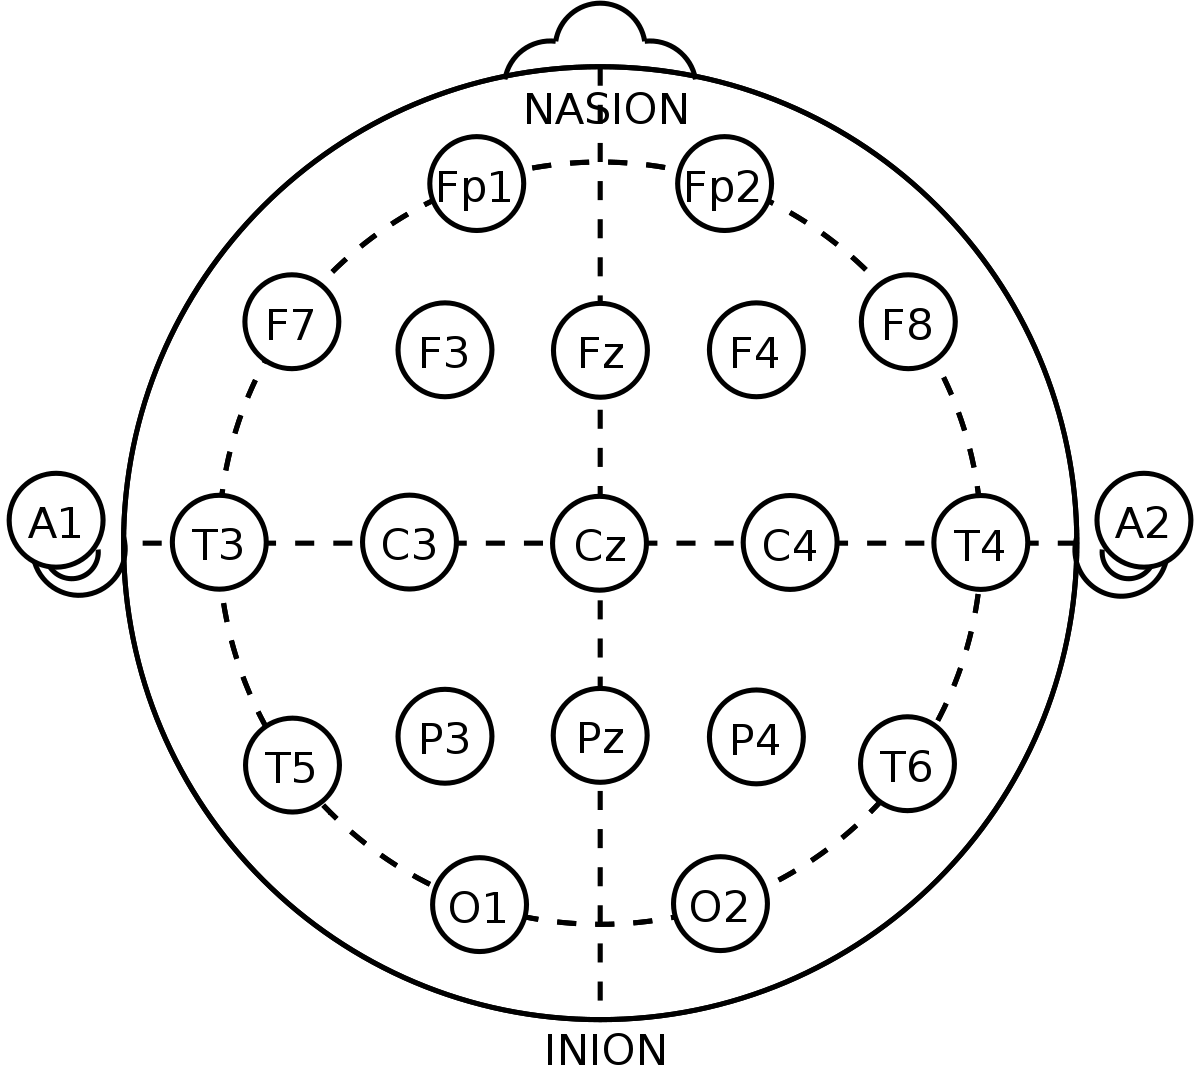

In [4]:
# We will discard all recordings that have an incomplete channel
# configuration (wrt the channels that we are interested in, i.e. the 21
# channels of the international 10-20-placement). The dataset is subdivided into
# recordings with 'le' and 'ar' reference which we will have to consider.

short_ch_names = sorted([
    'A1', 'A2',
    'FP1', 'FP2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2',
    'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'FZ', 'CZ', 'PZ'])
ar_ch_names = sorted([
    'EEG A1-REF', 'EEG A2-REF',
    'EEG FP1-REF', 'EEG FP2-REF', 'EEG F3-REF', 'EEG F4-REF', 'EEG C3-REF',
    'EEG C4-REF', 'EEG P3-REF', 'EEG P4-REF', 'EEG O1-REF', 'EEG O2-REF',
    'EEG F7-REF', 'EEG F8-REF', 'EEG T3-REF', 'EEG T4-REF', 'EEG T5-REF',
    'EEG T6-REF', 'EEG FZ-REF', 'EEG CZ-REF', 'EEG PZ-REF'])
le_ch_names = sorted([
    'EEG A1-LE', 'EEG A2-LE',
    'EEG FP1-LE', 'EEG FP2-LE', 'EEG F3-LE', 'EEG F4-LE', 'EEG C3-LE',
    'EEG C4-LE', 'EEG P3-LE', 'EEG P4-LE', 'EEG O1-LE', 'EEG O2-LE',
    'EEG F7-LE', 'EEG F8-LE', 'EEG T3-LE', 'EEG T4-LE', 'EEG T5-LE',
    'EEG T6-LE', 'EEG FZ-LE', 'EEG CZ-LE', 'EEG PZ-LE'])
assert len(short_ch_names) == len(ar_ch_names) == len(le_ch_names)
ar_ch_mapping = {ch_name: short_ch_name for ch_name, short_ch_name in zip(
    ar_ch_names, short_ch_names)}
le_ch_mapping = {ch_name: short_ch_name for ch_name, short_ch_name in zip(
    le_ch_names, short_ch_names)}
ch_mapping = {'ar': ar_ch_mapping, 'le': le_ch_mapping}


def select_by_channels(ds, ch_mapping):
    split_ids = []
    for i, d in enumerate(ds.datasets):
        ref = 'ar' if d.raw.ch_names[0].endswith('-REF') else 'le'
        # these are the channels we are looking for
        seta = set(ch_mapping[ref].keys())
        # these are the channels of the recoding
        setb = set(d.raw.ch_names)
        # if recording contains all channels we are looking for, include it
        if seta.issubset(setb):
            split_ids.append(i)
    return ds.split(split_ids)['0']

In [5]:
tuh_preproc = select_by_channels(tuh, ch_mapping)
tuh_preproc.description.head()

,path,year,month,day,subject,session,segment,age,gender,report,version,train,pathological
0,v2.0.0/edf/eval/normal/01_tcp_ar/041/00004196/...,2009,9,3,4196,3,0,53,F,CLINICAL HISTORY: Seizures.\nMEDICATIONS: Dil...,v2.0.0,False,False
1,v2.0.0/edf/eval/normal/01_tcp_ar/058/00005864/...,2009,9,3,5864,1,0,30,M,"CLINICAL HISTORY: Schizophrenia, memory loss.\...",v2.0.0,False,False
2,v2.0.0/edf/train/normal/01_tcp_ar/009/00000929...,2009,9,4,929,3,2,39,F,"CLINICAL HISTORY: Epilepsy, currently seizure...",v2.0.0,True,False
3,v2.0.0/edf/eval/normal/01_tcp_ar/058/00005851/...,2009,9,4,5851,1,1,65,F,CLINICAL HISTORY: Sixty-five-year-old woman w...,v2.0.0,False,False
4,v2.0.0/edf/train/normal/01_tcp_ar/059/00005909...,2009,9,9,5909,2,0,32,M,CLINICAL HISTORY: 32 year old male with episod...,v2.0.0,True,False


In [8]:
len(tuh_preproc.description)
# meaning every recording had the 21 channels available

2993

In [9]:
# Adding channel positions for each recording
# Upgrade: use the mapping for the channel column to produce clearer output

tuh_extended = tuh.description
channel_names = [] # np.empty(shape=(2993,))
for i in range(len(tuh.datasets)): 
    channel_names.append(tuh.datasets[i].raw.ch_names)
tuh_extended['channels'] = channel_names

In [10]:
tuh_extended.head()

,path,year,month,day,subject,session,segment,age,gender,report,version,train,pathological,channels
0,v2.0.0/edf/eval/normal/01_tcp_ar/041/00004196/...,2009,9,3,4196,3,0,53,F,CLINICAL HISTORY: Seizures.\nMEDICATIONS: Dil...,v2.0.0,False,False,"[EEG FP2-REF, EEG FP1-REF, EEG F4-REF, EEG F3-..."
1,v2.0.0/edf/eval/normal/01_tcp_ar/058/00005864/...,2009,9,3,5864,1,0,30,M,"CLINICAL HISTORY: Schizophrenia, memory loss.\...",v2.0.0,False,False,"[EEG FP2-REF, EEG FP1-REF, EEG F4-REF, EEG F3-..."
2,v2.0.0/edf/train/normal/01_tcp_ar/009/00000929...,2009,9,4,929,3,2,39,F,"CLINICAL HISTORY: Epilepsy, currently seizure...",v2.0.0,True,False,"[EEG FP1-REF, EEG FP2-REF, EEG F3-REF, EEG F4-..."
3,v2.0.0/edf/eval/normal/01_tcp_ar/058/00005851/...,2009,9,4,5851,1,1,65,F,CLINICAL HISTORY: Sixty-five-year-old woman w...,v2.0.0,False,False,"[EEG FP1-REF, EEG FP2-REF, EEG F3-REF, EEG F4-..."
4,v2.0.0/edf/train/normal/01_tcp_ar/059/00005909...,2009,9,9,5909,2,0,32,M,CLINICAL HISTORY: 32 year old male with episod...,v2.0.0,True,False,"[EEG FP1-REF, EEG FP2-REF, EEG F3-REF, EEG F4-..."


##### 2. Discard the first 60 seconds of every recording & use a maximum of 20 minutes

In [11]:
# for comparison, create column with the length of each recording

length = [] # np.empty(shape=(2993,))
for i in range(len(tuh.datasets)): 
    length.append(tuh.datasets[i].raw.n_times / tuh.datasets[i].raw.info['sfreq'])
tuh_extended['length'] = length

tuh_extended.head(5)

,path,year,month,day,subject,session,segment,age,gender,report,version,train,pathological,channels,length
0,v2.0.0/edf/eval/normal/01_tcp_ar/041/00004196/...,2009,9,3,4196,3,0,53,F,CLINICAL HISTORY: Seizures.\nMEDICATIONS: Dil...,v2.0.0,False,False,"[EEG FP2-REF, EEG FP1-REF, EEG F4-REF, EEG F3-...",1402.0
1,v2.0.0/edf/eval/normal/01_tcp_ar/058/00005864/...,2009,9,3,5864,1,0,30,M,"CLINICAL HISTORY: Schizophrenia, memory loss.\...",v2.0.0,False,False,"[EEG FP2-REF, EEG FP1-REF, EEG F4-REF, EEG F3-...",3023.0
2,v2.0.0/edf/train/normal/01_tcp_ar/009/00000929...,2009,9,4,929,3,2,39,F,"CLINICAL HISTORY: Epilepsy, currently seizure...",v2.0.0,True,False,"[EEG FP1-REF, EEG FP2-REF, EEG F3-REF, EEG F4-...",1187.0
3,v2.0.0/edf/eval/normal/01_tcp_ar/058/00005851/...,2009,9,4,5851,1,1,65,F,CLINICAL HISTORY: Sixty-five-year-old woman w...,v2.0.0,False,False,"[EEG FP1-REF, EEG FP2-REF, EEG F3-REF, EEG F4-...",1147.0
4,v2.0.0/edf/train/normal/01_tcp_ar/059/00005909...,2009,9,9,5909,2,0,32,M,CLINICAL HISTORY: 32 year old male with episod...,v2.0.0,True,False,"[EEG FP1-REF, EEG FP2-REF, EEG F3-REF, EEG F4-...",3009.0


In [6]:
# based on: https://mne.tools/stable/generated/mne.io.Raw.html#mne.io.Raw.crop

def select_by_duration(ds, tmin=0, tmax=None, include_tmax=True):
    if tmax is None:
        tmax = np.inf
    # determine length of the recordings and select based on tmin and tmax
    split_ids = []
    for d_i, d in enumerate(ds.datasets):
        duration = d.raw.n_times / d.raw.info['sfreq']
        if tmin < duration: # since if we crop 1min, there would be nothing left
            split_ids.append(d_i)
            tmax = min((d.raw.n_times - 1) / d.raw.info['sfreq'], tmax)
            d.raw.crop(tmin=tmin, tmax=tmax, include_tmax=include_tmax)
    return ds.split(split_ids)['0']

tmin = 1 * 60
# because we crop the first 60 seconds of each recording, this is how we keep a maximum 20 minutes of data
tmax = 21 * 60


# tuh_preproc = select_by_duration(tuh, tmin, tmax)

In [13]:
select_by_duration(tuh_preproc, tmin, tmax)

In [14]:
# Adding the cropped length of each recording to the DataFrame

tuh_extended = tuh_preproc.description
length = [] # np.empty(shape=(2993,))
for i in range(len(tuh_preproc.datasets)): 
    length.append(tuh_preproc.datasets[i].raw.n_times / tuh_preproc.datasets[i].raw.info['sfreq'])
tuh_extended['length'] = length

tuh_extended.head(5)

,path,year,month,day,subject,session,segment,age,gender,report,version,train,pathological,length
0,v2.0.0/edf/eval/normal/01_tcp_ar/041/00004196/...,2009,9,3,4196,3,0,53,F,CLINICAL HISTORY: Seizures.\nMEDICATIONS: Dil...,v2.0.0,False,False,1200.004
1,v2.0.0/edf/eval/normal/01_tcp_ar/058/00005864/...,2009,9,3,5864,1,0,30,M,"CLINICAL HISTORY: Schizophrenia, memory loss.\...",v2.0.0,False,False,1200.004
2,v2.0.0/edf/train/normal/01_tcp_ar/009/00000929...,2009,9,4,929,3,2,39,F,"CLINICAL HISTORY: Epilepsy, currently seizure...",v2.0.0,True,False,1127.000
3,v2.0.0/edf/eval/normal/01_tcp_ar/058/00005851/...,2009,9,4,5851,1,1,65,F,CLINICAL HISTORY: Sixty-five-year-old woman w...,v2.0.0,False,False,1087.000
4,v2.0.0/edf/train/normal/01_tcp_ar/059/00005909...,2009,9,9,5909,2,0,32,M,CLINICAL HISTORY: 32 year old male with episod...,v2.0.0,True,False,1087.000


##### Downsample recordings to 100 Hz and clip at $\pm800\mu$v
https://mne.tools/stable/generated/mne.io.Raw.html#mne.io.Raw.resample

In [7]:
tuh.datasets[0].raw.info['sfreq']
sfreq = 100


**Preprocessor Pipeline**

In [8]:
preprocessors = [
    Preprocessor(select_by_duration, tmin=tmin, tmax=tmax, include_tmax=True,
                 apply_on_array=False),
    Preprocessor('set_eeg_reference', ref_channels='average', ch_type='eeg'),
    Preprocessor(select_by_channels, mapping=ch_mapping,
                 apply_on_array=False),
    Preprocessor('pick_channels', ch_names=short_ch_names, ordered=True),
    Preprocessor(multiply, factor=1e6, apply_on_array=True),
    Preprocessor(np.clip, a_min=-800, a_max=800, apply_on_array=True),
    Preprocessor('resample', sfreq=sfreq),
]

In [9]:
def custom_rename_channels(raw, mapping):
    # rename channels which are dependent on referencing:
    # le: EEG 01-LE, ar: EEG 01-REF
    # mne fails if the mapping contains channels as keys that are not present
    # in the raw
    reference = raw.ch_names[0].split('-')[-1].lower()
    assert reference in ['le', 'ref'], 'unexpected referencing'
    reference = 'le' if reference == 'le' else 'ar'
    raw.rename_channels(mapping[reference])


def custom_crop(raw, tmin=0.0, tmax=None, include_tmax=True):
    # crop recordings to tmin – tmax. can be incomplete if recording
    # has lower duration than tmax
    # by default mne fails if tmax is bigger than duration
    tmax = min((raw.n_times - 1) / raw.info['sfreq'], tmax)
    raw.crop(tmin=tmin, tmax=tmax, include_tmax=include_tmax)

In [10]:
tmin = 1 * 60
tmax = 20 * 60
sfreq = 100

preprocessors = [
    Preprocessor(custom_crop, tmin=tmin, tmax=tmax, include_tmax=True,
                 apply_on_array=False),
    Preprocessor('set_eeg_reference', ref_channels='average', ch_type='eeg'),
    Preprocessor(custom_rename_channels, mapping=ch_mapping,
                 apply_on_array=False),
    Preprocessor('pick_channels', ch_names=short_ch_names, ordered=True),
    Preprocessor(multiply, factor=1e6, apply_on_array=True),
    Preprocessor(np.clip, a_min=-800, a_max=800, apply_on_array=True),
    Preprocessor('resample', sfreq=sfreq),
]

In [12]:
N_JOBS = 16
OUT_PATH = 'Output/'  # please insert actual output directory here
tuh_preproc = preprocess(
    concat_ds=tuh,
    preprocessors=preprocessors,
    n_jobs=N_JOBS,
    save_dir=OUT_PATH
)

In [ ]:
window_size_samples = 1000
window_stride_samples = 1000
# generate compute windows here and store them to disk
tuh_windows = create_fixed_length_windows(
    tuh_preproc,
    window_size_samples=window_size_samples,
    window_stride_samples=window_stride_samples,
    drop_last_window=False,
    n_jobs=N_JOBS,
)

for x, y, ind in tuh_windows:
    break